In [1]:
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, precision_recall_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import warnings
warnings.filterwarnings('ignore')

In [2]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
stop_words = set(stopwords.words('english'))

In [4]:
# Set the MLflow tracking URI 
mlflow.set_tracking_uri("file:./mlruns")

In [5]:
# Set the experiment name
experiment_name = "sms-spam-classification"
mlflow.set_experiment(experiment_name)

2025/03/04 21:12:54 INFO mlflow.tracking.fluent: Experiment with name 'sms-spam-classification' does not exist. Creating a new experiment.


<Experiment: artifact_location=('file:c:/Users/HP/OneDrive/Desktop/CMI/CMI Semester '
 '4/AML/AppliedMachineLearning/Assignment2/mlruns/130972181796319339'), creation_time=1741102974904, experiment_id='130972181796319339', last_update_time=1741102974904, lifecycle_stage='active', name='sms-spam-classification', tags={}>

In [6]:
# Load the datasets
train_df = pd.read_csv('./train.csv')
val_df = pd.read_csv('./validation.csv')
test_df = pd.read_csv('./test.csv')

In [7]:
train_df

,label,message
0,0,Hey!!! I almost forgot ... Happy B-day babe ! ...
1,0,Pls confirm the time to collect the cheque.
2,0,Just sleeping..and surfing
3,1,Dear Dave this is your final notice to collect...
4,0,"Sorry, I'll call later"
...,...,...
3338,1,"FreeMsg Hey U, i just got 1 of these video/pic..."
3339,0,Cab is available.they pick up and drop at door...
3340,0,Omg you can make a wedding chapel in frontierv...
3341,0,"Storming msg: Wen u lift d phne, u say ""HELLO""..."


In [8]:
val_df

,label,message
0,0,"K, my roommate also wants a dubsack and anothe..."
1,0,"Fuck babe, I miss you sooooo much !! I wish yo..."
2,1,You are a winner U have been specially selecte...
3,0,Waaaat?? Lololo ok next time then!
4,0,I like cheap! But iâm happy to splash out on...
...,...,...
1388,0,"Just wondering, the others just took off"
1389,0,I HAVE A DATE ON SUNDAY WITH WILL!!
1390,0,Forgot to tell Ã¼ smth.. Can Ã¼ like number th...
1391,0,How stupid to say that i challenge god.You don...


In [9]:
test_df

,label,message
0,0,What not under standing.
1,0,Anything lor if they all go then i go lor...
2,1,CALL 09090900040 & LISTEN TO EXTREME DIRTY LIV...
3,0,Ffffffffff. Alright no way I can meet up with ...
4,1,Free msg: Single? Find a partner in your area!...
...,...,...
831,0,Hey gals.. Anyone of u going down to e driving...
832,1,Don't b floppy... b snappy & happy! Only gay c...
833,0,As in different styles?
834,0,"Same, I'm at my great aunts anniversary party ..."


In [10]:
# Function to preprocess data
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return ' '.join(tokens)

In [11]:

def prepare_data(data):
    data['processed_message'] = data['message'].apply(preprocess_text)
    # Extract messages and labels
    messages = data['processed_message'].values
    labels = data['label'].values
    
    return messages, labels

In [12]:
# Prepare the data
X_train, y_train = prepare_data(train_df)
X_val, y_val = prepare_data(val_df)
X_test, y_test = prepare_data(test_df)

In [13]:
# Print distribution of target variable
print("Data distribution:")
print(f"Train data: {len(y_train)} samples, {sum(y_train)} spam, {len(y_train) - sum(y_train)} ham")
print(f"Validation data: {len(y_val)} samples, {sum(y_val)} spam, {len(y_val) - sum(y_val)} ham")
print(f"Test data: {len(y_test)} samples, {sum(y_test)} spam, {len(y_test) - sum(y_test)} ham")

Data distribution:
Train data: 3343 samples, 431 spam, 2912 ham
Validation data: 1393 samples, 193 spam, 1200 ham
Test data: 836 samples, 123 spam, 713 ham


In [14]:
# Function to calculate AUCPR
def calculate_aucpr(model, X, y):
    y_scores = model.predict_proba(X)[:, 1]
    precision, recall, _ = precision_recall_curve(y, y_scores)
    aucpr = auc(recall, precision)
    return aucpr

In [ ]:
# Function to evaluate and log the models
def evaluate_and_log_model(model_name, pipeline, run_name=None):
    # Start MLflow run
    with mlflow.start_run(run_name=run_name):
        # Log the model parameters
        model_params = pipeline.named_steps[model_name].get_params()
        for param_name, param_value in model_params.items():
            mlflow.log_param(f"{model_name}_{param_name}", param_value)
        
        # Train the model
        pipeline.fit(X_train, y_train)
        
        # Evaluate the model
        train_accuracy = accuracy_score(y_train, pipeline.predict(X_train))
        val_accuracy = accuracy_score(y_val, pipeline.predict(X_val))
        test_accuracy = accuracy_score(y_test, pipeline.predict(X_test))
        
        # Calculate AUCPR
        train_aucpr = calculate_aucpr(pipeline, X_train, y_train)
        val_aucpr = calculate_aucpr(pipeline, X_val, y_val)
        test_aucpr = calculate_aucpr(pipeline, X_test, y_test)
        
        # Log metrics
        mlflow.log_metric("train_accuracy", train_accuracy)
        mlflow.log_metric("val_accuracy", val_accuracy)
        mlflow.log_metric("test_accuracy", test_accuracy)
        mlflow.log_metric("train_aucpr", train_aucpr)
        mlflow.log_metric("val_aucpr", val_aucpr)
        mlflow.log_metric("test_aucpr", test_aucpr)
        
        # Generate and log classification report
        val_report = classification_report(y_val, pipeline.predict(X_val))
        with open("classification_report.txt", "w") as f:
            f.write(val_report)
        mlflow.log_artifact("classification_report.txt")
        
        # Create and log PR curve figure
        plt.figure(figsize=(10, 6))
        y_scores = pipeline.predict_proba(X_val)[:, 1]
        precision, recall, _ = precision_recall_curve(y_val, y_scores)
        plt.plot(recall, precision, label=f'AUCPR = {val_aucpr:.3f}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve - {model_name}')
        plt.legend()
        plt.savefig("pr_curve.png")
        mlflow.log_artifact("pr_curve.png")
        
        # Register the model
        mlflow.sklearn.log_model(
            pipeline, 
            "model",
            registered_model_name=model_name,
            input_example=X_train[:1]
        )
        
        # Print results
        print(f"Model: {model_name}")
        print(f"Train Accuracy: {train_accuracy:.4f}")
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f}")
        print(f"Train AUCPR: {train_aucpr:.4f}")
        print(f"Validation AUCPR: {val_aucpr:.4f}")
        print(f"Test AUCPR: {test_aucpr:.4f}")
        print("Classification Report:")
        print(val_report)
        print("\n")
        
    return pipeline

#### Building and evaluating models...

Registered model 'nb' already exists. Creating a new version of this model...


Model: nb
Train Accuracy: 0.9779
Validation Accuracy: 0.9555
Test Accuracy: 0.9629
Train AUCPR: 0.9792
Validation AUCPR: 0.9456
Test AUCPR: 0.9520
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1200
           1       1.00      0.68      0.81       193

    accuracy                           0.96      1393
   macro avg       0.98      0.84      0.89      1393
weighted avg       0.96      0.96      0.95      1393





Created version '3' of model 'nb'.


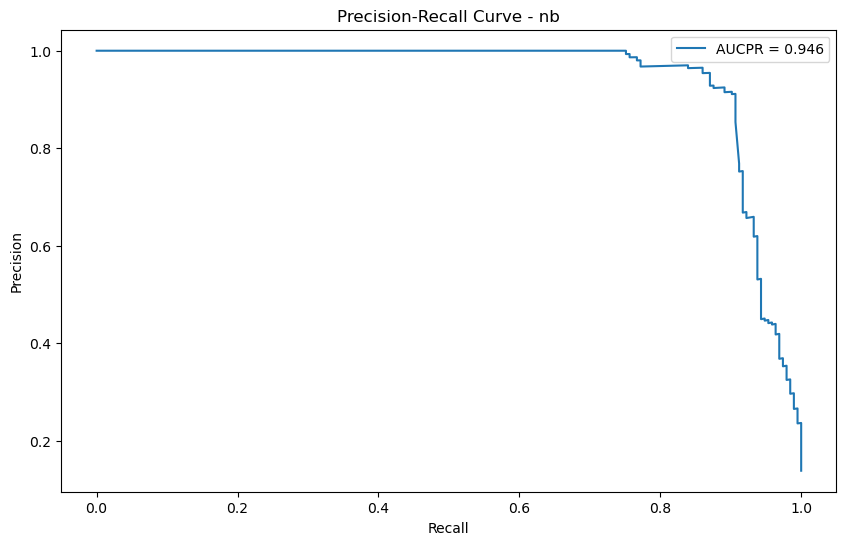

In [20]:
# 1. Naive Bayes
nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
    ('nb', MultinomialNB())
])
nb_model = evaluate_and_log_model('nb', nb_pipeline, run_name="Naive Bayes")

Successfully registered model 'logreg'.
Created version '1' of model 'logreg'.


Model: logreg
Train Accuracy: 0.9662
Validation Accuracy: 0.9526
Test Accuracy: 0.9581
Train AUCPR: 0.9850
Validation AUCPR: 0.9275
Test AUCPR: 0.9570
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1200
           1       0.98      0.67      0.80       193

    accuracy                           0.95      1393
   macro avg       0.97      0.83      0.88      1393
weighted avg       0.95      0.95      0.95      1393





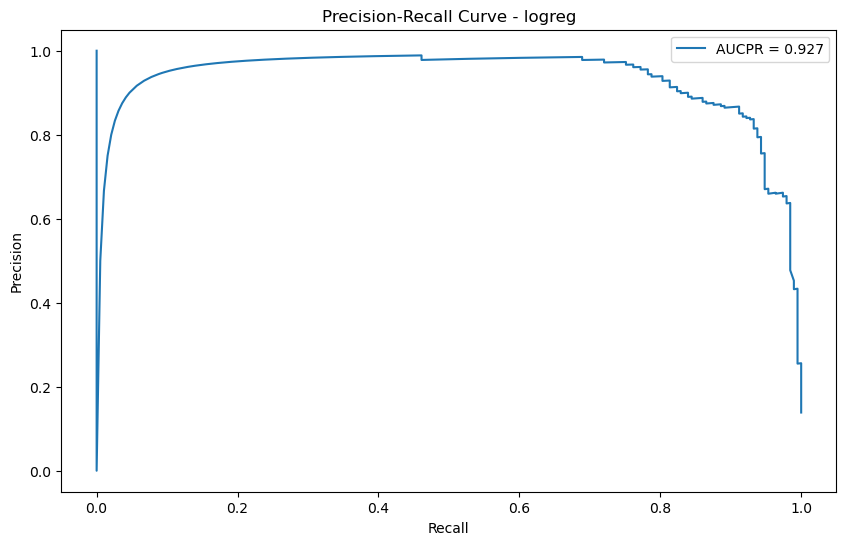

In [21]:
# 2. Logistic Regression
lr_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
    ('logreg', LogisticRegression(max_iter=1000, random_state=42))
])
lr_model = evaluate_and_log_model('logreg', lr_pipeline, run_name="Logistic Regression")

Successfully registered model 'rf'.


Model: rf
Train Accuracy: 0.9997
Validation Accuracy: 0.9663
Test Accuracy: 0.9773
Train AUCPR: 0.9992
Validation AUCPR: 0.9560
Test AUCPR: 0.9504
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1200
           1       1.00      0.76      0.86       193

    accuracy                           0.97      1393
   macro avg       0.98      0.88      0.92      1393
weighted avg       0.97      0.97      0.96      1393





Created version '1' of model 'rf'.


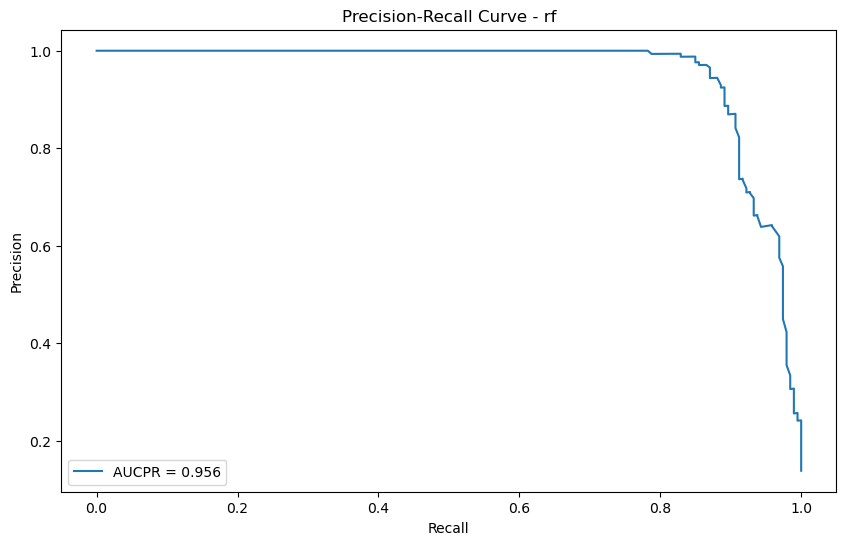

In [22]:
# 3. Random Forest
rf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
])
rf_model = evaluate_and_log_model('rf', rf_pipeline, run_name="Random Forest")

In [23]:
# Retrieve and compare model metrics
client = mlflow.tracking.MlflowClient()

In [24]:
# Fetch the most recent version of each model
models = ["logreg", "nb", "rf"]
latest_versions = {}

In [25]:
print("\nModel comparison (AUCPR on validation set):")
print("-" * 50)

for model_name in models:
    versions = client.get_latest_versions(model_name, stages=["None"])
    if versions:
        latest_version = versions[0]
        latest_versions[model_name] = latest_version.version
        
        # Get run info
        run = client.get_run(latest_version.run_id)
        val_aucpr = run.data.metrics.get("val_aucpr", 0.0)
        
        print(f"{model_name} (version {latest_version.version}): AUCPR = {val_aucpr:.4f}")



Model comparison (AUCPR on validation set):
--------------------------------------------------
logreg (version 1): AUCPR = 0.9275
nb (version 3): AUCPR = 0.9456
rf (version 1): AUCPR = 0.9560


In [26]:
# Identify the best model
best_model = None
best_aucpr = 0.0

In [27]:
for model_name in models:
    versions = client.get_latest_versions(model_name, stages=["None"])
    if versions:
        run = client.get_run(versions[0].run_id)
        val_aucpr = run.data.metrics.get("val_aucpr", 0.0)
        
        if val_aucpr > best_aucpr:
            best_aucpr = val_aucpr
            best_model = model_name

In [28]:
print(f"\nBest model based on validation AUCPR: {best_model} with AUCPR = {best_aucpr:.4f}")


Best model based on validation AUCPR: rf with AUCPR = 0.9560


In [29]:
# Optional: Promote the best model to production
if best_model:
    client.transition_model_version_stage(
        name=best_model,
        version=latest_versions[best_model],
        stage="Production"
    )
    print(f"Model {best_model} (version {latest_versions[best_model]}) has been promoted to Production.")

Model rf (version 1) has been promoted to Production.


In [30]:
print("\nMLflow tracking URI:", mlflow.get_tracking_uri())
print("Experiment ID:", mlflow.get_experiment_by_name(experiment_name).experiment_id)
print("Models have been tracked and registered. You can view the results in the MLflow UI.")


MLflow tracking URI: file:./mlruns
Experiment ID: 130972181796319339
Models have been tracked and registered. You can view the results in the MLflow UI.
